# Setup

### Activate inline plotting

In [1]:
%pylab inline
import sys
sys.path.insert(0, '..')

Populating the interactive namespace from numpy and matplotlib


### Import Dataset(s)

In [2]:
from data import Dataset

In [3]:
signal = Dataset('../data/signal_TDR.root')

### Drawing Function(s)

In [4]:
def setup_plot_for_detector(size=(15, 15)):
    figsize(*size)
    axes(polar=True)
    # set appropriate
    ylim(0, 85)   

### Sandbox

In [5]:
print sorted(set(signal.track_rhos))
print len(set(signal.track_phis))

[18.0, 26.050000000000001, 34.100000000000001, 42.150000000000006, 50.200000000000003]
20


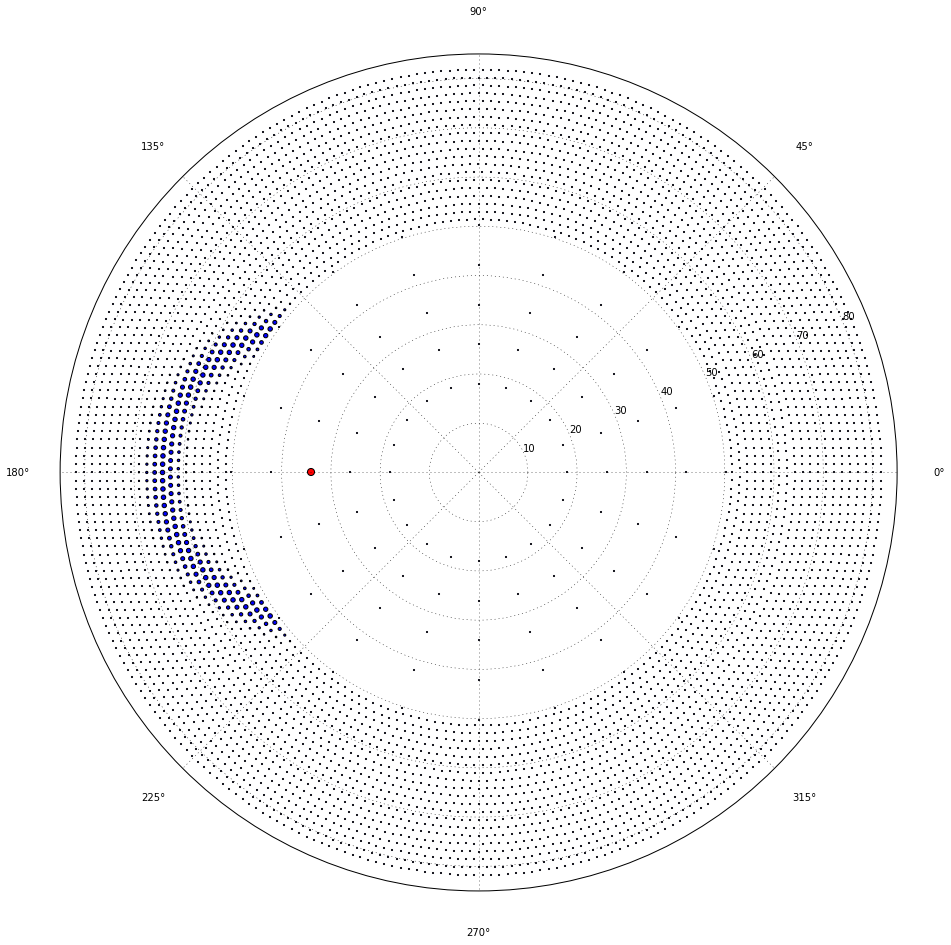

In [8]:
trk_0 = 50
corr_track = find(signal.correspondence[:,trk_0])[0]
signal_size = find(signal.correspondence[:,trk_0])[2]
setup_plot_for_detector()
rhos, phis = signal.get_wires_rhos_and_phis()
t_rhos, t_phis = signal.get_tracks_rhos_and_phis()
scatter(phis, rhos, marker='.', s=5)
scatter(t_phis, t_rhos, marker='.', s=5)

scatter(phis[corr_track],rhos[corr_track], signal_size*100, marker='o', c='b')
scatter(t_phis[trk_0],t_rhos[trk_0], marker='o', s=50, c='r')